In [1]:
ls ../dnftresult

OneDCyclic_fordebug_baseline/  one_dim_cyclic_fordebug_baseline/
OneDsignal_fordebug_baseline/  one_dim_signal_fordebug_baseline/


In [2]:
import sys
import yaml
sys.path.append('../')
import os
import torch
from misc import yaml_util as yu
sys.path.append('../dataset')
sys.path.append('../module')
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from misc import character_analysis as ca


In [3]:
# datname = 'one_dim_signal'
datname = 'one_dim_cyclic'
modelname = 'fordebug'
#modelname = 'mlp1layer_nonDim'
# modelname = 'mask1layer'

trainname = 'baseline'
with open(f'''../cfg_data/{datname}.yaml''', 'rb') as f:
    cfg_data = yaml.safe_load(f)

cfg_data['args']['shift_label'] = True
mydata = yu.load_component(cfg_data) 

myloader = DataLoader(mydata, batch_size=20,
                        shuffle=True, 
                        num_workers=1,
                        )


seq, shift =  mydata[0]
seq = seq[None, :]
print(seq.shape)

exp_name = f'''{datname}_{modelname}_{trainname}'''

exppath = os.path.join("../dnftresult", exp_name)
if not os.path.exists(exppath):
    raise NotImplementedError
mymodelpath = f"""{exppath}/model.pt"""
mymodel = torch.load(mymodelpath)
mymodel = mymodel.to(0)
mymodel

./dataset/cyclic_group_signal.py
torch.Size([1, 3, 220])


NFT(
  (encoder): MLPEncoder(
    (activation_fxn): Tanh()
    (net): Sequential(
      (0): MaskFlatLinear()
      (1): Tanh()
      (2): MaskFlatLinear()
      (3): Tanh()
      (4): MaskFlatLinear()
    )
  )
  (decoder): MLPDecoder(
    (activation_fxn): Tanh()
    (net): Sequential(
      (0): MaskFlatLinear()
      (1): Tanh()
      (2): MaskFlatLinear()
      (3): Tanh()
      (4): MaskFlatLinear()
    )
  )
)

In [4]:
Ms = []
shifts = [] 
for k in range(100):
    evalseq, shift = next(iter(myloader))
    evalseq = evalseq[:, :2].to(mymodel.encoder.device)
    predicted = mymodel(evalseq, n_rolls=1)
    shifts.append(shift)
    Ms.append(mymodel.dynamics.M) 
    
shifts = torch.concatenate(shifts)
Ms = torch.concatenate(Ms)

In [5]:
from importlib import reload
reload(ca)
targfreq, prods = ca.inner_prod(Ms, shifts, maxfreq=64, bins=65)

100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


AttributeError: 'CyclicGroupSignal' object has no attribute 'freqsel'

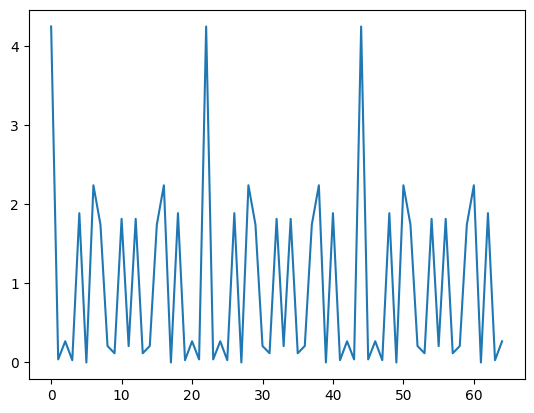

In [6]:
plt.figure()
plt.plot(targfreq, prods, label='learnt')
deltas = ca.deltafxn(targfreq, mydata.freqsel)*2
plt.plot(targfreq, deltas, label='gt',alpha=0.5)

plt.title(f"""Frequencies learnt from datasets with Freq:{mydata.freqsel}""")
plt.legend()

In [ ]:
modelname